# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk import word_tokenize
nltk.download('punkt_tab')
import re
import string
import emoji
import html

from transformers import pipeline

pd.options.display.max_rows = None  # Change to higher value if needed
pd.options.display.max_columns = 50  # Increase columns shown
pd.options.display.max_colwidth = 100  # Expand column width


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\axeln\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Import Dataset

In [87]:
# df = pd.read_csv('./merge_tweets.csv')
df = pd.read_csv('./new_tweets/tweets1.csv')
df1 = pd.read_csv('./new_tweets/tweets2.csv')
df2 = pd.read_csv('./new_tweets/tweets3.csv')
df3 = pd.read_csv('./new_tweets/tweets4.csv')
df4 = pd.read_csv('./new_tweets/tweets5(tukin_dosenASN).csv')
df5 = pd.read_csv('./new_tweets/tweets6(keyword_adaksi).csv')
# df.info()

In [88]:
# combined df and df1 into one dataframe and drop the same tweets by 'id'
df = pd.concat([df, df1, df2, df3, df4, df5], ignore_index=True)
df.drop_duplicates(subset='id', inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              526 non-null    int64  
 1   created_at      526 non-null    object 
 2   user            526 non-null    object 
 3   location        402 non-null    object 
 4   text            526 non-null    object 
 5   in_reply_to     168 non-null    float64
 6   reply_count     526 non-null    int64  
 7   favorite_count  526 non-null    int64  
 8   hashtags        526 non-null    object 
dtypes: float64(1), int64(3), object(5)
memory usage: 37.1+ KB


# Preprocess Data

In [89]:
# import indonesia stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')
idn_stopwords = set(stopwords.words('indonesian'))
print(idn_stopwords)

{'kenapa', 'pertama-tama', 'terutama', 'dikatakan', 'tiga', 'ingin', 'luar', 'bersiap', 'itulah', 'per', 'mengakhiri', 'entahlah', 'menanyakan', 'jadinya', 'selamanya', 'tegas', 'membuat', 'sebabnya', 'diketahuinya', 'bukankah', 'diinginkan', 'inginkah', 'katakanlah', 'beginian', 'mungkin', 'seperti', 'sebaik', 'kelamaan', 'lima', 'setempat', 'sendirinya', 'betul', 'sebanyak', 'pun', 'padahal', 'kamu', 'sepertinya', 'tentulah', 'pula', 'masing-masing', 'sesuatunya', 'berlalu', 'yang', 'sebegitu', 'semua', 'artinya', 'jadi', 'berdatangan', 'pada', 'diberikannya', 'keinginan', 'menyangkut', 'turut', 'semata-mata', 'ditambahkan', 'berjumlah', 'kinilah', 'mengira', 'semakin', 'tadi', 'keduanya', 'beberapa', 'itu', 'sampai-sampai', 'kedua', 'seenaknya', 'sebagainya', 'dua', 'kok', 'menjawab', 'bekerja', 'berkali-kali', 'justru', 'waktu', 'menantikan', 'melihatnya', 'kamulah', 'berkenaan', 'sesekali', 'meyakinkan', 'masa', 'tertentu', 'seingat', 'ungkap', 'jawab', 'sepantasnyalah', 'makin', 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\axeln\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [90]:
def clean_text(text): # cleaning text from punctuation, url, mention, number, and emoji
    text = str(text).lower()  # Convert to lowercase
    text = html.unescape(text)  # Convert HTML entities
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    # text = re.sub(r"#(\w+)", r"\1", text)  # Remove '#' but keep word
    text = re.sub(r"#\w+", "", text)  # Remove '#' and the words following
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = emoji.replace_emoji(text, replace="")  # Remove emojis
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

def remove_nonalphanumeric(text):  # remove non-alphanumeric characters
    text = re.sub('&amp;', ' ', text)  
    text = re.sub('[^0-9a-zA-Z,.]+', ' ', text)  # Hapus tanda tanya dari regex  
    text = re.sub('  +', ' ', text)  
    return text

def remove_stopwords(text): # remove stopwords
    text = ' '.join([word for word in text.split() if word not in idn_stopwords])
    return text

def slang_fix(text): # fix slang words
    text = re.sub(r'\b(aj|ae|aja)\b', 'saja', text)
    text = re.sub(r'\b(ak|gue|gw)\b','aku', text)
    text = re.sub(r'\b(belom|blm)\b', 'belum', text)
    text = re.sub(r'\b(bgt|bngt)\b', 'banget', text)
    text = re.sub(r'\b(bnyk|byk)\b', 'banyak', text)
    text = re.sub(r'\b(dlm)\b', 'dalam', text)
    text = re.sub(r'\b(dr)\b', 'dari', text)
    text = re.sub(r'\b(dg|dgn)\b','dengan',text )
    text = re.sub(r'\b(dpt|dapet)\b', 'dapat', text)
    text = re.sub(r'\b(duar+)\b', 'duar', text)
    text = re.sub(r'\b(emg|emang)\b', 'memang', text)
    text = re.sub(r'\b(gt|gtu)\b', 'gitu', text)
    text = re.sub(r'\b(gatau)\b', 'tidak tau', text)
    text = re.sub(r'\b(gaada)\b', 'tidak ada', text)
    text = re.sub(r'\b(gamau)\b', 'tidak mau', text)
    text = re.sub(r'\b(gimana|gmn)\b', 'bagaimana', text)
    text = re.sub(r'\b(jgn)\b', 'jangan', text)
    text = re.sub(r'\b(jgn2|jangan2)\b', 'jangan jangan', text)
    text = re.sub(r'\b(jd|jdi)\b', 'jadi', text)
    text = re.sub(r'\b(karna|krn|krna)\b', 'karena', text)
    text = re.sub(r'\b(kyk|kek)\b', 'kayak', text)
    text = re.sub(r'\b(kl|klo|kalo)\b', 'kalau', text)
    text = re.sub(r'\b(klian)\b', 'kalian', text)
    text = re.sub(r'\b(knp)\b', 'kenapa', text)
    text = re.sub(r'\b(kpd)\b', 'kepada', text)
    text = re.sub(r'\b(lg)\b', 'lagi', text)
    text = re.sub(r'\b(lgsg)\b', 'langsung', text)
    text = re.sub(r'\b(mrk)\b', 'mereka', text)
    text = re.sub(r'\b(pd)\b', 'pada', text)
    text = re.sub(r'\b(pdhl)\b', 'padahal', text)
    text = re.sub(r'\b(pake)\b', 'pakai', text)
    text = re.sub(r'\b(org)\b', 'orang', text)
    text = re.sub(r'\b(org2)\b', 'orang orang', text)
    text = re.sub(r'\b(sbg)\b', 'sebagai', text)
    text = re.sub(r'\b(skrg)\b', 'sekarang', text)
    text = re.sub(r'\b(sm)\b', 'sama', text)
    text = re.sub(r'\b(spt)\b', 'seperti', text)
    text = re.sub(r'\b(dah|sdh|udh|udah)\b', 'sudah', text)
    text = re.sub(r'\b(tp|tpi)\b', 'tapi', text)
    text = re.sub(r'\b(tiba2|tbtb|tb2)\b', 'tiba tiba', text)
    text = re.sub(r'\b(td|tdi)\b', 'tadi', text)
    text = re.sub(r'\b(tdk|g|ga|gak|gk|engga|enggak|ngga|nggak|kaga|kagak)\b', 'tidak', text)
    text = re.sub(r'\b(trus|trs)\b', 'terus', text)
    text = re.sub(r'\b(tsb)\b', 'tersebut', text)
    text = re.sub(r'\b(ttg)\b', 'tentang', text)
    text = re.sub(r'\b(utk)\b', 'untuk', text)
    text = re.sub(r'\b(ya+h*)\b', 'ya', text)
    text = re.sub(r'\b(yg)\b', 'yang', text)
    return text

def cleaning_text(text): # cleaning text
    text = clean_text(text)
    text = remove_nonalphanumeric(text)
    text = slang_fix(text)
    return text

In [91]:
# copy the original dataframe into the new one for preprocessing
data = df[['id', 'created_at', 'user', 'text', 'hashtags']].copy()
data.rename(columns={'text': 'ori_text'}, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          526 non-null    int64 
 1   created_at  526 non-null    object
 2   user        526 non-null    object
 3   ori_text    526 non-null    object
 4   hashtags    526 non-null    object
dtypes: int64(1), object(4)
memory usage: 20.7+ KB


In [92]:
data['cleaned_text'] = data['ori_text'].apply(cleaning_text) # apply cleaning text function for tweets
data['cleaned_hashtags'] = data['hashtags'].apply(cleaning_text) # apply cleaning text function for hashtags
data.head()

,id,created_at,user,ori_text,hashtags,cleaned_text,cleaned_hashtags
0,1889617201092518227,2025-02-12 10:07:02+00:00,Suci Lestari Yuana,Minggu pertama kuliah di UGM dimulai dengan demo aksi solidaritas untuk Tukin Dosen ASN Kemendik...,"['TukinforAll', 'BerserikatKitaKuat']",minggu pertama kuliah di ugm dimulai dengan demo aksi solidaritas untuk tukin dosen asn kemendik...,tukinforall berserikatkitakuat
1,1886459678508318807,2025-02-03 17:00:10+00:00,𝕭𝖆𝖓𝖌 𝕴𝖖𝖇𝖆𝖑,"Dosen sudah memberikan kewajiban, tapi haknya tak kunjung diberikan.\n\nKami hanya tidak ingin n...","['bayartukindosenkemdiktisaintek', 'tukinforall', 'dosenbukansapiperah', 'DosenDimiskinkanNegara']",dosen sudah memberikan kewajiban tapi haknya tak kunjung diberikan kami hanya tidak ingin nantin...,bayartukindosenkemdiktisaintek tukinforall dosenbukansapiperah dosendimiskinkannegara
2,1886233966434484231,2025-02-03 02:03:16+00:00,Pejuang Tukin Dosen ASN Kemendiktisaintek,Perjuangan ini akan terus berlanjut sampai keadilan untuk kesejahteraan dosen terwujud\n#bayartu...,"['bayartukindosenkemdiktisaintek', 'dosenbukansapiperah', 'tukinforall']",perjuangan ini akan terus berlanjut sampai keadilan untuk kesejahteraan dosen terwujud,bayartukindosenkemdiktisaintek dosenbukansapiperah tukinforall
3,1886286035233247552,2025-02-03 05:30:10+00:00,Nadhifah Al Indis,Kami tdk meminta naik gaji. Kami hanya menuntut HAK sesuai UU ASN yg tdk ditunaikan oleh pemerin...,"['tukinforall', 'bayartukindosenkemdiktisaintek', 'dosenbukansapiperah']",kami tidak meminta naik gaji kami hanya menuntut hak sesuai uu asn yang tidak ditunaikan oleh pe...,tukinforall bayartukindosenkemdiktisaintek dosenbukansapiperah
4,1886218908497334278,2025-02-03 01:03:26+00:00,Muhammad Sajidin,"Ya Allah Lindungilah Mereka yang sedang memperjuangkan Hak Kami, Hindarilah Kami Dari pemimpin y...","['tukinforall', 'bayartukindosenkemdiktisaintek', 'dosenbukansapiperah']",ya allah lindungilah mereka yang sedang memperjuangkan hak kami hindarilah kami dari pemimpin ya...,tukinforall bayartukindosenkemdiktisaintek dosenbukansapiperah


In [93]:
data['cleaned_text_no_stopwords'] = data['cleaned_text'].apply(remove_stopwords) # remove stopwords from tweets
data.head()

,id,created_at,user,ori_text,hashtags,cleaned_text,cleaned_hashtags,cleaned_text_no_stopwords
0,1889617201092518227,2025-02-12 10:07:02+00:00,Suci Lestari Yuana,Minggu pertama kuliah di UGM dimulai dengan demo aksi solidaritas untuk Tukin Dosen ASN Kemendik...,"['TukinforAll', 'BerserikatKitaKuat']",minggu pertama kuliah di ugm dimulai dengan demo aksi solidaritas untuk tukin dosen asn kemendik...,tukinforall berserikatkitakuat,minggu kuliah ugm demo aksi solidaritas tukin dosen asn kemendiktisaintek kampusmu
1,1886459678508318807,2025-02-03 17:00:10+00:00,𝕭𝖆𝖓𝖌 𝕴𝖖𝖇𝖆𝖑,"Dosen sudah memberikan kewajiban, tapi haknya tak kunjung diberikan.\n\nKami hanya tidak ingin n...","['bayartukindosenkemdiktisaintek', 'tukinforall', 'dosenbukansapiperah', 'DosenDimiskinkanNegara']",dosen sudah memberikan kewajiban tapi haknya tak kunjung diberikan kami hanya tidak ingin nantin...,bayartukindosenkemdiktisaintek tukinforall dosenbukansapiperah dosendimiskinkannegara,dosen kewajiban haknya kunjung pemerintah merengek memaksa dosen mencerdaskan masyarakat sulit d...
2,1886233966434484231,2025-02-03 02:03:16+00:00,Pejuang Tukin Dosen ASN Kemendiktisaintek,Perjuangan ini akan terus berlanjut sampai keadilan untuk kesejahteraan dosen terwujud\n#bayartu...,"['bayartukindosenkemdiktisaintek', 'dosenbukansapiperah', 'tukinforall']",perjuangan ini akan terus berlanjut sampai keadilan untuk kesejahteraan dosen terwujud,bayartukindosenkemdiktisaintek dosenbukansapiperah tukinforall,perjuangan berlanjut keadilan kesejahteraan dosen terwujud
3,1886286035233247552,2025-02-03 05:30:10+00:00,Nadhifah Al Indis,Kami tdk meminta naik gaji. Kami hanya menuntut HAK sesuai UU ASN yg tdk ditunaikan oleh pemerin...,"['tukinforall', 'bayartukindosenkemdiktisaintek', 'dosenbukansapiperah']",kami tidak meminta naik gaji kami hanya menuntut hak sesuai uu asn yang tidak ditunaikan oleh pe...,tukinforall bayartukindosenkemdiktisaintek dosenbukansapiperah,gaji menuntut hak sesuai uu asn ditunaikan pemerintah semoga dosen asn kemsiktisaintek memperjua...
4,1886218908497334278,2025-02-03 01:03:26+00:00,Muhammad Sajidin,"Ya Allah Lindungilah Mereka yang sedang memperjuangkan Hak Kami, Hindarilah Kami Dari pemimpin y...","['tukinforall', 'bayartukindosenkemdiktisaintek', 'dosenbukansapiperah']",ya allah lindungilah mereka yang sedang memperjuangkan hak kami hindarilah kami dari pemimpin ya...,tukinforall bayartukindosenkemdiktisaintek dosenbukansapiperah,ya allah lindungilah memperjuangkan hak hindarilah pemimpin dzalim aamiin


# Getting Sentiments

In [94]:
sentiment_pipeline = pipeline("sentiment-analysis", model="ayameRushia/bert-base-indonesian-1.5G-sentiment-analysis-smsa", tokenizer="ayameRushia/bert-base-indonesian-1.5G-sentiment-analysis-smsa")

Device set to use cpu


In [95]:
def get_sentiment(text):
    result = sentiment_pipeline(text)
    return result[0]['label']

data['label'] = data['cleaned_text_no_stopwords'].apply(get_sentiment)
data.head()

,id,created_at,user,ori_text,hashtags,cleaned_text,cleaned_hashtags,cleaned_text_no_stopwords,label
0,1889617201092518227,2025-02-12 10:07:02+00:00,Suci Lestari Yuana,Minggu pertama kuliah di UGM dimulai dengan demo aksi solidaritas untuk Tukin Dosen ASN Kemendik...,"['TukinforAll', 'BerserikatKitaKuat']",minggu pertama kuliah di ugm dimulai dengan demo aksi solidaritas untuk tukin dosen asn kemendik...,tukinforall berserikatkitakuat,minggu kuliah ugm demo aksi solidaritas tukin dosen asn kemendiktisaintek kampusmu,Neutral
1,1886459678508318807,2025-02-03 17:00:10+00:00,𝕭𝖆𝖓𝖌 𝕴𝖖𝖇𝖆𝖑,"Dosen sudah memberikan kewajiban, tapi haknya tak kunjung diberikan.\n\nKami hanya tidak ingin n...","['bayartukindosenkemdiktisaintek', 'tukinforall', 'dosenbukansapiperah', 'DosenDimiskinkanNegara']",dosen sudah memberikan kewajiban tapi haknya tak kunjung diberikan kami hanya tidak ingin nantin...,bayartukindosenkemdiktisaintek tukinforall dosenbukansapiperah dosendimiskinkannegara,dosen kewajiban haknya kunjung pemerintah merengek memaksa dosen mencerdaskan masyarakat sulit d...,Negative
2,1886233966434484231,2025-02-03 02:03:16+00:00,Pejuang Tukin Dosen ASN Kemendiktisaintek,Perjuangan ini akan terus berlanjut sampai keadilan untuk kesejahteraan dosen terwujud\n#bayartu...,"['bayartukindosenkemdiktisaintek', 'dosenbukansapiperah', 'tukinforall']",perjuangan ini akan terus berlanjut sampai keadilan untuk kesejahteraan dosen terwujud,bayartukindosenkemdiktisaintek dosenbukansapiperah tukinforall,perjuangan berlanjut keadilan kesejahteraan dosen terwujud,Positive
3,1886286035233247552,2025-02-03 05:30:10+00:00,Nadhifah Al Indis,Kami tdk meminta naik gaji. Kami hanya menuntut HAK sesuai UU ASN yg tdk ditunaikan oleh pemerin...,"['tukinforall', 'bayartukindosenkemdiktisaintek', 'dosenbukansapiperah']",kami tidak meminta naik gaji kami hanya menuntut hak sesuai uu asn yang tidak ditunaikan oleh pe...,tukinforall bayartukindosenkemdiktisaintek dosenbukansapiperah,gaji menuntut hak sesuai uu asn ditunaikan pemerintah semoga dosen asn kemsiktisaintek memperjua...,Negative
4,1886218908497334278,2025-02-03 01:03:26+00:00,Muhammad Sajidin,"Ya Allah Lindungilah Mereka yang sedang memperjuangkan Hak Kami, Hindarilah Kami Dari pemimpin y...","['tukinforall', 'bayartukindosenkemdiktisaintek', 'dosenbukansapiperah']",ya allah lindungilah mereka yang sedang memperjuangkan hak kami hindarilah kami dari pemimpin ya...,tukinforall bayartukindosenkemdiktisaintek dosenbukansapiperah,ya allah lindungilah memperjuangkan hak hindarilah pemimpin dzalim aamiin,Negative


In [96]:
data.to_csv('./labeled_tweets.csv', index=False)

# Preprocess Data (Again)

In [97]:
data.head()

,id,created_at,user,ori_text,hashtags,cleaned_text,cleaned_hashtags,cleaned_text_no_stopwords,label
0,1889617201092518227,2025-02-12 10:07:02+00:00,Suci Lestari Yuana,Minggu pertama kuliah di UGM dimulai dengan demo aksi solidaritas untuk Tukin Dosen ASN Kemendik...,"['TukinforAll', 'BerserikatKitaKuat']",minggu pertama kuliah di ugm dimulai dengan demo aksi solidaritas untuk tukin dosen asn kemendik...,tukinforall berserikatkitakuat,minggu kuliah ugm demo aksi solidaritas tukin dosen asn kemendiktisaintek kampusmu,Neutral
1,1886459678508318807,2025-02-03 17:00:10+00:00,𝕭𝖆𝖓𝖌 𝕴𝖖𝖇𝖆𝖑,"Dosen sudah memberikan kewajiban, tapi haknya tak kunjung diberikan.\n\nKami hanya tidak ingin n...","['bayartukindosenkemdiktisaintek', 'tukinforall', 'dosenbukansapiperah', 'DosenDimiskinkanNegara']",dosen sudah memberikan kewajiban tapi haknya tak kunjung diberikan kami hanya tidak ingin nantin...,bayartukindosenkemdiktisaintek tukinforall dosenbukansapiperah dosendimiskinkannegara,dosen kewajiban haknya kunjung pemerintah merengek memaksa dosen mencerdaskan masyarakat sulit d...,Negative
2,1886233966434484231,2025-02-03 02:03:16+00:00,Pejuang Tukin Dosen ASN Kemendiktisaintek,Perjuangan ini akan terus berlanjut sampai keadilan untuk kesejahteraan dosen terwujud\n#bayartu...,"['bayartukindosenkemdiktisaintek', 'dosenbukansapiperah', 'tukinforall']",perjuangan ini akan terus berlanjut sampai keadilan untuk kesejahteraan dosen terwujud,bayartukindosenkemdiktisaintek dosenbukansapiperah tukinforall,perjuangan berlanjut keadilan kesejahteraan dosen terwujud,Positive
3,1886286035233247552,2025-02-03 05:30:10+00:00,Nadhifah Al Indis,Kami tdk meminta naik gaji. Kami hanya menuntut HAK sesuai UU ASN yg tdk ditunaikan oleh pemerin...,"['tukinforall', 'bayartukindosenkemdiktisaintek', 'dosenbukansapiperah']",kami tidak meminta naik gaji kami hanya menuntut hak sesuai uu asn yang tidak ditunaikan oleh pe...,tukinforall bayartukindosenkemdiktisaintek dosenbukansapiperah,gaji menuntut hak sesuai uu asn ditunaikan pemerintah semoga dosen asn kemsiktisaintek memperjua...,Negative
4,1886218908497334278,2025-02-03 01:03:26+00:00,Muhammad Sajidin,"Ya Allah Lindungilah Mereka yang sedang memperjuangkan Hak Kami, Hindarilah Kami Dari pemimpin y...","['tukinforall', 'bayartukindosenkemdiktisaintek', 'dosenbukansapiperah']",ya allah lindungilah mereka yang sedang memperjuangkan hak kami hindarilah kami dari pemimpin ya...,tukinforall bayartukindosenkemdiktisaintek dosenbukansapiperah,ya allah lindungilah memperjuangkan hak hindarilah pemimpin dzalim aamiin,Negative


In [98]:
# dropping id column
data.drop(columns=['id'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   created_at                 526 non-null    object
 1   user                       526 non-null    object
 2   ori_text                   526 non-null    object
 3   hashtags                   526 non-null    object
 4   cleaned_text               526 non-null    object
 5   cleaned_hashtags           526 non-null    object
 6   cleaned_text_no_stopwords  526 non-null    object
 7   label                      526 non-null    object
dtypes: object(8)
memory usage: 33.0+ KB


In [99]:
# changing 'created_at' columnn into datetime format
data['created_at'] = pd.to_datetime(data['created_at'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   created_at                 526 non-null    datetime64[ns, UTC]
 1   user                       526 non-null    object             
 2   ori_text                   526 non-null    object             
 3   hashtags                   526 non-null    object             
 4   cleaned_text               526 non-null    object             
 5   cleaned_hashtags           526 non-null    object             
 6   cleaned_text_no_stopwords  526 non-null    object             
 7   label                      526 non-null    object             
dtypes: datetime64[ns, UTC](1), object(7)
memory usage: 33.0+ KB


## New Dataset for Making Timeseries Plot

In [100]:
data_time = data.copy()
data_time.set_index('created_at', inplace=True)
data_time.head()

,user,ori_text,hashtags,cleaned_text,cleaned_hashtags,cleaned_text_no_stopwords,label
created_at,,,,,,,
2025-02-12 10:07:02+00:00,Suci Lestari Yuana,Minggu pertama kuliah di UGM dimulai dengan demo aksi solidaritas untuk Tukin Dosen ASN Kemendik...,"['TukinforAll', 'BerserikatKitaKuat']",minggu pertama kuliah di ugm dimulai dengan demo aksi solidaritas untuk tukin dosen asn kemendik...,tukinforall berserikatkitakuat,minggu kuliah ugm demo aksi solidaritas tukin dosen asn kemendiktisaintek kampusmu,Neutral
2025-02-03 17:00:10+00:00,𝕭𝖆𝖓𝖌 𝕴𝖖𝖇𝖆𝖑,"Dosen sudah memberikan kewajiban, tapi haknya tak kunjung diberikan.\n\nKami hanya tidak ingin n...","['bayartukindosenkemdiktisaintek', 'tukinforall', 'dosenbukansapiperah', 'DosenDimiskinkanNegara']",dosen sudah memberikan kewajiban tapi haknya tak kunjung diberikan kami hanya tidak ingin nantin...,bayartukindosenkemdiktisaintek tukinforall dosenbukansapiperah dosendimiskinkannegara,dosen kewajiban haknya kunjung pemerintah merengek memaksa dosen mencerdaskan masyarakat sulit d...,Negative
2025-02-03 02:03:16+00:00,Pejuang Tukin Dosen ASN Kemendiktisaintek,Perjuangan ini akan terus berlanjut sampai keadilan untuk kesejahteraan dosen terwujud\n#bayartu...,"['bayartukindosenkemdiktisaintek', 'dosenbukansapiperah', 'tukinforall']",perjuangan ini akan terus berlanjut sampai keadilan untuk kesejahteraan dosen terwujud,bayartukindosenkemdiktisaintek dosenbukansapiperah tukinforall,perjuangan berlanjut keadilan kesejahteraan dosen terwujud,Positive
2025-02-03 05:30:10+00:00,Nadhifah Al Indis,Kami tdk meminta naik gaji. Kami hanya menuntut HAK sesuai UU ASN yg tdk ditunaikan oleh pemerin...,"['tukinforall', 'bayartukindosenkemdiktisaintek', 'dosenbukansapiperah']",kami tidak meminta naik gaji kami hanya menuntut hak sesuai uu asn yang tidak ditunaikan oleh pe...,tukinforall bayartukindosenkemdiktisaintek dosenbukansapiperah,gaji menuntut hak sesuai uu asn ditunaikan pemerintah semoga dosen asn kemsiktisaintek memperjua...,Negative
2025-02-03 01:03:26+00:00,Muhammad Sajidin,"Ya Allah Lindungilah Mereka yang sedang memperjuangkan Hak Kami, Hindarilah Kami Dari pemimpin y...","['tukinforall', 'bayartukindosenkemdiktisaintek', 'dosenbukansapiperah']",ya allah lindungilah mereka yang sedang memperjuangkan hak kami hindarilah kami dari pemimpin ya...,tukinforall bayartukindosenkemdiktisaintek dosenbukansapiperah,ya allah lindungilah memperjuangkan hak hindarilah pemimpin dzalim aamiin,Negative


In [101]:
# grouping data by date
data_time = data_time.resample('D').count()

In [102]:
data_time.head()

,user,ori_text,hashtags,cleaned_text,cleaned_hashtags,cleaned_text_no_stopwords,label
created_at,,,,,,,
2025-01-05 00:00:00+00:00,1,1,1,1,1,1,1
2025-01-06 00:00:00+00:00,19,19,19,19,19,19,19
2025-01-07 00:00:00+00:00,3,3,3,3,3,3,3
2025-01-08 00:00:00+00:00,0,0,0,0,0,0,0
2025-01-09 00:00:00+00:00,1,1,1,1,1,1,1


In [103]:
data_time = data_time['cleaned_text_no_stopwords']
data_time.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 45 entries, 2025-01-05 00:00:00+00:00 to 2025-02-18 00:00:00+00:00
Freq: D
Series name: cleaned_text_no_stopwords
Non-Null Count  Dtype
--------------  -----
45 non-null     int64
dtypes: int64(1)
memory usage: 720.0 bytes


In [104]:
data_time.to_csv('./time_series.csv')

# Exploratory Data Analysis

In [105]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   created_at                 526 non-null    datetime64[ns, UTC]
 1   user                       526 non-null    object             
 2   ori_text                   526 non-null    object             
 3   hashtags                   526 non-null    object             
 4   cleaned_text               526 non-null    object             
 5   cleaned_hashtags           526 non-null    object             
 6   cleaned_text_no_stopwords  526 non-null    object             
 7   label                      526 non-null    object             
dtypes: datetime64[ns, UTC](1), object(7)
memory usage: 33.0+ KB


## Comparing Sentiments

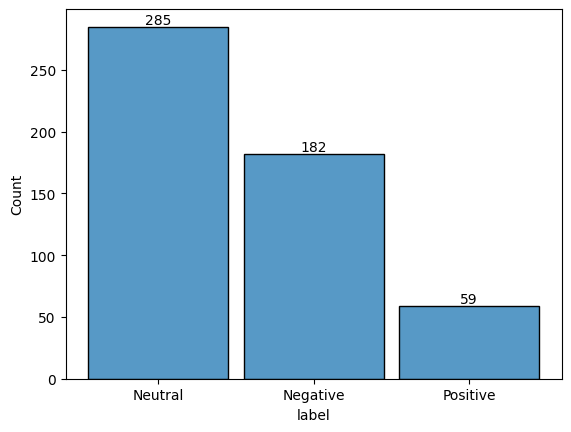

In [106]:
ax = sns.histplot(data['label'], shrink=0.9)
ax.bar_label(ax.containers[0])

plt.show()

## Positive Sentiment Wordcloud

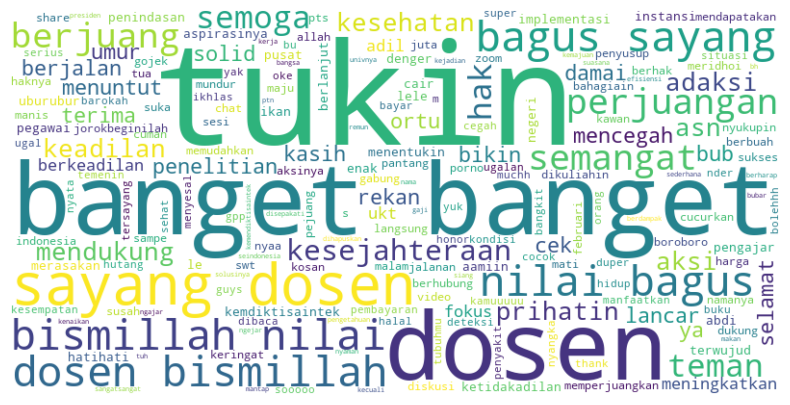

In [107]:
# wordcloud for positive sentiment
positive_text = ' '.join(data[data['label'] == 'Positive']['cleaned_text_no_stopwords'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Negative Sentiment Wordcloud

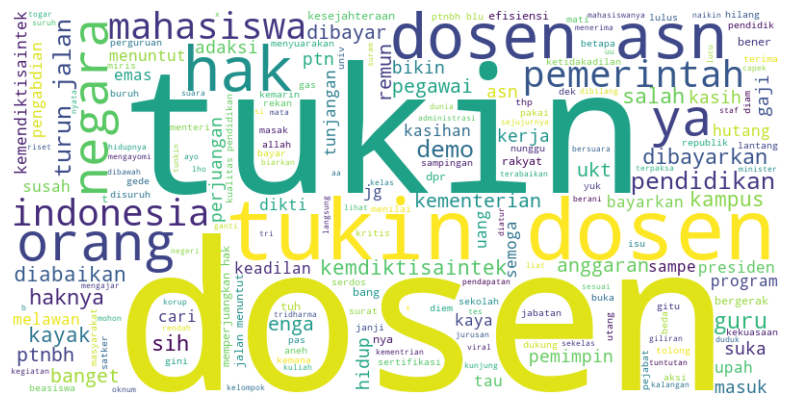

In [108]:
# wordcloud for negative sentiment
negative_text = ' '.join(data[data['label'] == 'Negative']['cleaned_text_no_stopwords'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Neutral Sentiment Wordcloud

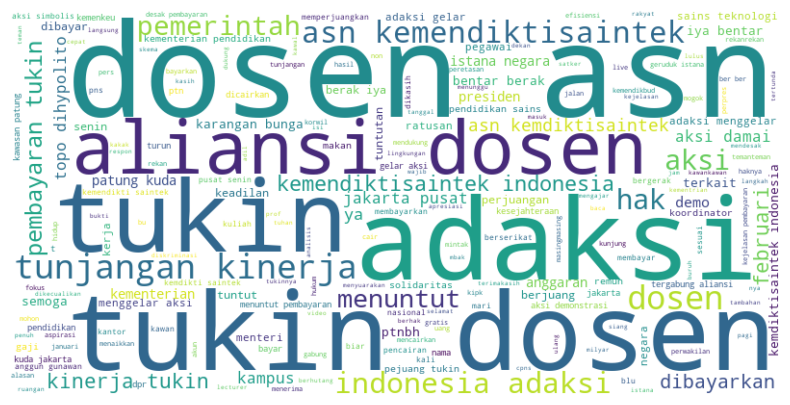

In [109]:
# wordcloud for neutral sentiment
neutral_text = ' '.join(data[data['label'] == 'Neutral']['cleaned_text_no_stopwords'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neutral_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Time Series Plot for Tweet

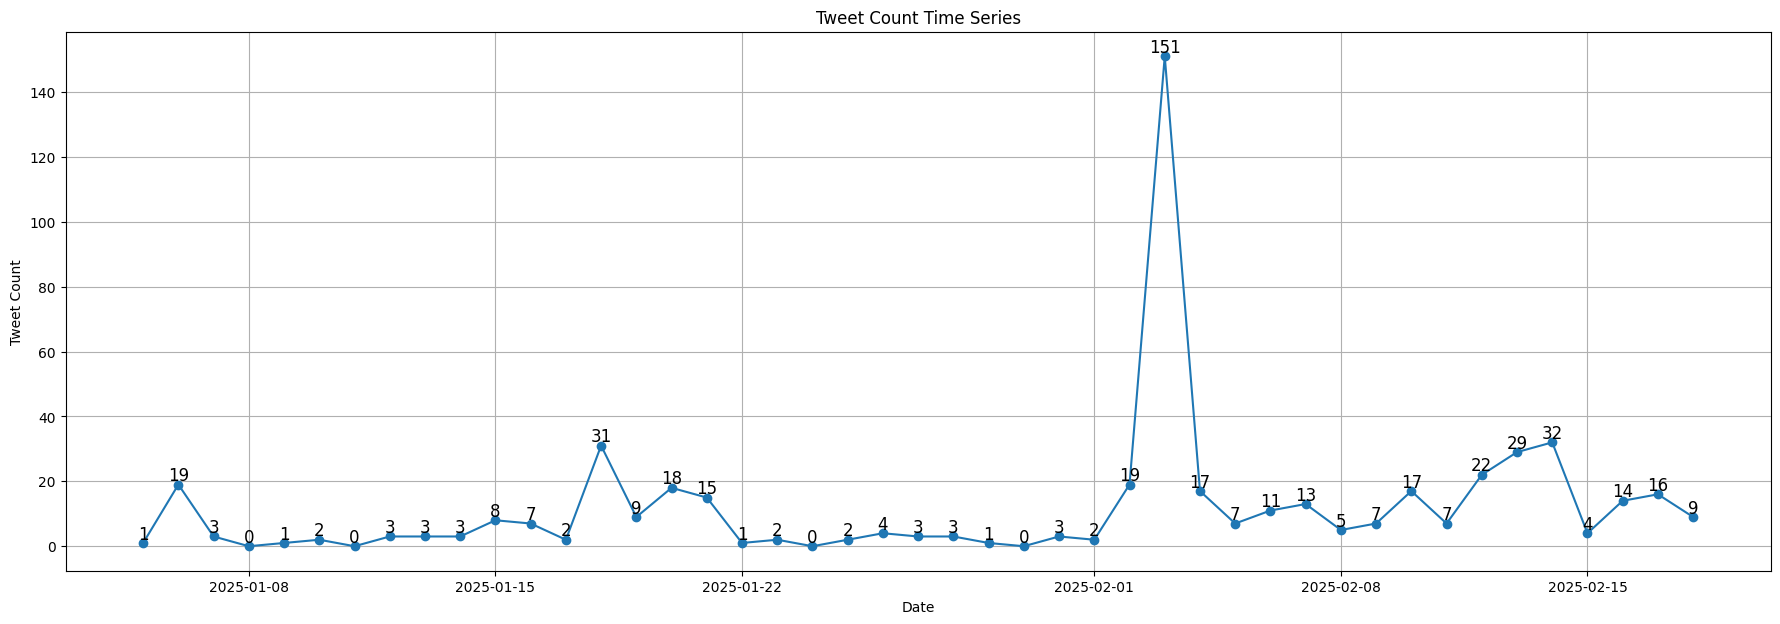

In [110]:
# Create the plot
plt.figure(figsize=(22, 7))
plt.plot(data_time.index, data_time, marker='o', linestyle='-')  # Add markers

# Add labels on top of markers
for x, y in zip(data_time.index, data_time):
    plt.text(x, y, str(y), ha='center', va='bottom', fontsize=12, color='black')

# Formatting
plt.title('Tweet Count Time Series')
plt.xlabel('Date')
plt.ylabel('Tweet Count')
plt.grid()

plt.show()

In [111]:
# getting the top 5 days with the most tweets
data_time.sort_values(ascending=False).head()

created_at
2025-02-03 00:00:00+00:00    151
2025-02-14 00:00:00+00:00     32
2025-01-18 00:00:00+00:00     31
2025-02-13 00:00:00+00:00     29
2025-02-12 00:00:00+00:00     22
Name: cleaned_text_no_stopwords, dtype: int64

## Getting the Tweets in 3 February 2025

In [112]:
# df_copy = df.copy()
# df_copy['created_at'] = pd.to_datetime(df_copy['created_at'])
# df_copy.loc[df_copy['created_at'].dt.date == pd.to_datetime('2025-02-03').date()]


In [113]:
# getting the tweets in 2025-02-03

data_3feb2025 = data[data['created_at'].dt.date == pd.to_datetime('2025-02-03').date()][['user', 'cleaned_text','cleaned_hashtags']]

In [114]:
print(len(data_3feb2025))

151
